<a href="https://colab.research.google.com/github/mtavionics/Face-Detection-/blob/main/Deep_Learning_Face_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing packages

- keras - deep learning
- scikit-learn - general purpose machine learning
- imbalanced-learn - methods that address class imbalance problem

In [1]:
!pip install keras scikit-learn imbalanced-learn


### Let's verify that we have a GPU available

The following cell should output a GPU device 0 with `name: Tesla K80`

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15910970796123857045, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11297803469
 locality {
   bus_id: 1
 }
 incarnation: 17126381139771622431
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

### Imports that we'll use along the way

- numpy - linear algebra
- keras - deep learning
- sklearn.dataset - to download Labeled Faces in the Wild dataset
- sklearn.model_selection - for dataset train/test split
- sklearn.metrics - to measure the performance of our classifier
- matplotlib.pyplot - showing images and plots
- imblearn.over_sampling - random oversampling method to handle class imalance

In [ ]:
import numpy as np
import keras
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

### Labeled Faces in the Wild dataset

The cell below downloads the dataset using `fetch_lfw_people` function and checks the dimensionality of the datset.

There are some parameters that control e.g. the minimum number of images per class (person), image size, etc.

Here is a link to the function's documentation: [fetch_lfw_people](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html).

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, color=True, resize=1.0,
                              slice_=(slice(48, 202), slice(48, 202)))

X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('number of examples: {}'.format(y.shape[0]))
print('dimensionality of images: {}'.format(X.shape[1:]))
print('number of unique classes (people): {}'.format(n_classes))

/usr/local/lib/python2.7/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python2.7/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


number of examples: 3023
dimensionality of images: (154, 154, 3)
number of unique classes (people): 62


Let's plot a histogram showing how many examples per class we have.

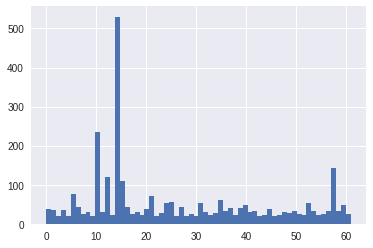

In [ ]:
_ = plt.hist(y, bins=n_classes)

Since the dataset contains images, we'll display a random image together with its label.

Bill Clinton


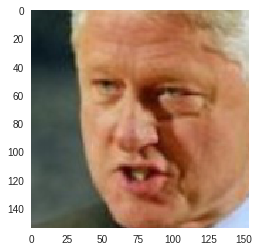

In [ ]:
i = np.random.randint(len(lfw_people.images))
plt.imshow(lfw_people.images[i] * 255)
plt.grid(False)
print(target_names[y[i]])

### Deep learning

Now let's get down to deep learning and build an All Convolutional Net inspired model [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806).

First, we need to import some layer objects from Keras.

In [ ]:
from keras.layers import Input
from keras.layers import Conv2D, GlobalAvgPool2D
from keras.layers import Dropout, Activation

Below we define our model.
It consists of 10 convolutional layers with increasing number of filters (from 12 to 48).
Every second layer has kernels of size `(2, 2)` with strides `(2, 2)` and serves the purpose of a trainable pooling layer since it reduces spacial dimensionality.
After that, we add Dropout for regularization which sets 50% of randomly chosen activations to 0.
Then, we add the last convolutional layer for dimensionality expansion to match the number of classes that we predict.
Finallly, we apply global average polling to squash spacial dimenaions.
We could do that with another convolutional layer or a fully connected leyer, however, it would increase the number of weights to train and, in turn, a risk of overfitting.


In [ ]:
input = Input(shape=X.shape[1:])                                  # 154x154x3
x = Conv2D(12, (3, 3), padding='same', activation='relu')(input)  # 154x154x12
x = Conv2D(12, (2, 2), strides=(2, 2), activation='relu')(x)      # 77x77x12
x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)      # 77x77x16
x = Conv2D(16, (2, 2), strides=(2, 2), activation='relu')(x)      # 38x38x16
x = Conv2D(24, (3, 3), padding='same', activation='relu')(x)      # 38x38x24
x = Conv2D(24, (2, 2), strides=(2, 2), activation='relu')(x)      # 19x19x24
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)      # 19x19x32
x = Conv2D(32, (2, 2), strides=(2, 2), activation='relu')(x)      # 9x9x32
x = Conv2D(48, (3, 3), padding='same', activation='relu')(x)      # 9x9x48
x = Conv2D(48, (2, 2), strides=(2, 2), activation='relu')(x)      # 4x4x48
x = Dropout(0.5)(x)                                               # 4x4x48
x = Conv2D(n_classes, (1, 1))(x)                                  # 4x4x62
x = GlobalAvgPool2D()(x)                                          # 62
output = Activation('softmax')(x)                                 # 62

Now, let's create a `DataGenerator` object that will add some data augmentation to prevent overfitting.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1)

### Training

At this point we are ready to define training procedure that involves setting some hyperparameters, e.g. batch size, optimization algorithm and base learning rate, number of epochs, etc.

In addition, since we know that our dataset is imbalanced, it's good to use oversampling.

In [ ]:
from keras import Model

batch_size = 256
test_split = 0.2
base_lr = 0.001
epochs = 100

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, 
                                                    stratify=y, random_state=42)

# oversampling each class to contain at least 256 examples
sampling_targets = np.maximum([256] * n_classes, np.bincount(y_train))
ratio_dict = dict(zip(range(n_classes), sampling_targets))
ros = RandomOverSampler(ratio=ratio_dict, random_state=42)

X_train_shape = X_train.shape
X_train = np.reshape(X_train, (X_train_shape[0], -1))
X_train, y_train = ros.fit_sample(X_train, y_train)
X_train = np.reshape(X_train, (len(X_train),) + X_train_shape[1:])

# one-hot encoding of labels
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

# compile model and define optimization
model = Model(inputs=input, outputs=output)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(lr=base_lr),
              metrics=['accuracy'])

# model training
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/128
62/62 [==============================] - 93s 2s/step - loss: 4.1549 - acc: 0.0243 - val_loss: 4.0266 - val_acc: 0.1752
Epoch 2/128
62/62 [==============================] - 91s 1s/step - loss: 4.0150 - acc: 0.0350 - val_loss: 3.8089 - val_acc: 0.1190
Epoch 3/128
62/62 [==============================] - 91s 1s/step - loss: 3.8287 - acc: 0.0553 - val_loss: 3.6891 - val_acc: 0.1587
Epoch 4/128
62/62 [==============================] - 91s 1s/step - loss: 3.6779 - acc: 0.0759 - val_loss: 3.4797 - val_acc: 0.1752
Epoch 5/128
44/62 [====================>.........] - ETA: 26s - loss: 3.6152 - acc: 0.0890

62/62 [==============================] - 91s 1s/step - loss: 3.5986 - acc: 0.0907 - val_loss: 3.3945 - val_acc: 0.2000
Epoch 6/128
62/62 [==============================] - 92s 1s/step - loss: 3.3877 - acc: 0.1295 - val_loss: 3.2339 - val_acc: 0.1802
Epoch 7/128
62/62 [==============================] - 91s 1s/step - loss: 3.2536 - acc: 0.1561 - val_loss: 3.2256 - val_acc: 0.1818
Epoch 8/128
62/62 [==============================] - 91s 1s/step - loss: 3.0902 - acc: 0.1872 - val_loss: 3.0979 - val_acc: 0.2149
Epoch 9/128
56/62 [==========================>...] - ETA: 8s - loss: 2.9581 - acc: 0.2190

62/62 [==============================] - 88s 1s/step - loss: 2.9550 - acc: 0.2178 - val_loss: 2.9953 - val_acc: 0.2397
Epoch 10/128
62/62 [==============================] - 88s 1s/step - loss: 2.7991 - acc: 0.2462 - val_loss: 2.6670 - val_acc: 0.3025
Epoch 11/128
62/62 [==============================] - 90s 1s/step - loss: 2.6567 - acc: 0.2729 - val_loss: 2.6240 - val_acc: 0.3256
Epoch 12/128
62/62 [==============================] - 93s 1s/step - loss: 2.5469 - acc: 0.3047 - val_loss: 2.7578 - val_acc: 0.2777
Epoch 13/128
56/62 [==========================>...] - ETA: 8s - loss: 2.4011 - acc: 0.3366 

62/62 [==============================] - 91s 1s/step - loss: 2.3991 - acc: 0.3370 - val_loss: 2.3658 - val_acc: 0.3868
Epoch 14/128
62/62 [==============================] - 92s 1s/step - loss: 2.3281 - acc: 0.3549 - val_loss: 2.3768 - val_acc: 0.3620
Epoch 15/128
62/62 [==============================] - 92s 1s/step - loss: 2.1760 - acc: 0.3918 - val_loss: 2.2447 - val_acc: 0.3835
Epoch 16/128
62/62 [==============================] - 92s 1s/step - loss: 2.0922 - acc: 0.4136 - val_loss: 2.1022 - val_acc: 0.4182
Epoch 17/128
56/62 [==========================>...] - ETA: 8s - loss: 1.9886 - acc: 0.4394 

62/62 [==============================] - 92s 1s/step - loss: 1.9755 - acc: 0.4428 - val_loss: 1.9073 - val_acc: 0.4926
Epoch 18/128
62/62 [==============================] - 91s 1s/step - loss: 1.8972 - acc: 0.4615 - val_loss: 1.8825 - val_acc: 0.5041
Epoch 19/128
62/62 [==============================] - 92s 1s/step - loss: 1.7584 - acc: 0.4922 - val_loss: 2.0269 - val_acc: 0.4198
Epoch 20/128
62/62 [==============================] - 91s 1s/step - loss: 1.7326 - acc: 0.5013 - val_loss: 1.6829 - val_acc: 0.5256
Epoch 21/128
56/62 [==========================>...] - ETA: 8s - loss: 1.6494 - acc: 0.5166 

62/62 [==============================] - 92s 1s/step - loss: 1.6400 - acc: 0.5186 - val_loss: 1.6068 - val_acc: 0.5504
Epoch 22/128
62/62 [==============================] - 91s 1s/step - loss: 1.5726 - acc: 0.5396 - val_loss: 1.6500 - val_acc: 0.5438
Epoch 23/128
62/62 [==============================] - 92s 1s/step - loss: 1.4958 - acc: 0.5602 - val_loss: 1.5297 - val_acc: 0.5736
Epoch 24/128
62/62 [==============================] - 92s 1s/step - loss: 1.4155 - acc: 0.5846 - val_loss: 1.5990 - val_acc: 0.5785
Epoch 25/128
56/62 [==========================>...] - ETA: 8s - loss: 1.3901 - acc: 0.5873 

62/62 [==============================] - 91s 1s/step - loss: 1.3887 - acc: 0.5879 - val_loss: 1.4205 - val_acc: 0.5983
Epoch 26/128
62/62 [==============================] - 92s 1s/step - loss: 1.3031 - acc: 0.6056 - val_loss: 1.2850 - val_acc: 0.6347
Epoch 27/128
62/62 [==============================] - 92s 1s/step - loss: 1.2658 - acc: 0.6191 - val_loss: 1.6459 - val_acc: 0.5322
Epoch 28/128
62/62 [==============================] - 91s 1s/step - loss: 1.1973 - acc: 0.6448 - val_loss: 1.4113 - val_acc: 0.6033
Epoch 29/128
56/62 [==========================>...] - ETA: 8s - loss: 1.1443 - acc: 0.6523 

62/62 [==============================] - 92s 1s/step - loss: 1.1394 - acc: 0.6532 - val_loss: 1.2531 - val_acc: 0.6496
Epoch 30/128
62/62 [==============================] - 91s 1s/step - loss: 1.1057 - acc: 0.6636 - val_loss: 1.2306 - val_acc: 0.6529
Epoch 31/128
62/62 [==============================] - 92s 1s/step - loss: 1.0543 - acc: 0.6811 - val_loss: 1.2372 - val_acc: 0.6479
Epoch 32/128
62/62 [==============================] - 91s 1s/step - loss: 1.0248 - acc: 0.6843 - val_loss: 1.2243 - val_acc: 0.6711
Epoch 33/128
56/62 [==========================>...] - ETA: 8s - loss: 1.0450 - acc: 0.6858 

62/62 [==============================] - 92s 1s/step - loss: 1.0408 - acc: 0.6859 - val_loss: 1.0859 - val_acc: 0.6909
Epoch 34/128
62/62 [==============================] - 92s 1s/step - loss: 0.9410 - acc: 0.7047 - val_loss: 1.1047 - val_acc: 0.6959
Epoch 35/128
62/62 [==============================] - 91s 1s/step - loss: 0.9403 - acc: 0.7171 - val_loss: 1.0796 - val_acc: 0.7140
Epoch 36/128
62/62 [==============================] - 92s 1s/step - loss: 0.9084 - acc: 0.7184 - val_loss: 1.1694 - val_acc: 0.6777
Epoch 37/128
56/62 [==========================>...] - ETA: 8s - loss: 0.8658 - acc: 0.7343 

62/62 [==============================] - 92s 1s/step - loss: 0.8627 - acc: 0.7359 - val_loss: 0.9668 - val_acc: 0.7372
Epoch 38/128
62/62 [==============================] - 92s 1s/step - loss: 0.8381 - acc: 0.7386 - val_loss: 1.1339 - val_acc: 0.6694
Epoch 39/128
62/62 [==============================] - 92s 1s/step - loss: 0.8209 - acc: 0.7511 - val_loss: 1.0184 - val_acc: 0.7140
Epoch 40/128
62/62 [==============================] - 92s 1s/step - loss: 0.7916 - acc: 0.7562 - val_loss: 0.9812 - val_acc: 0.7190
Epoch 41/128
56/62 [==========================>...] - ETA: 8s - loss: 0.7387 - acc: 0.7689 

62/62 [==============================] - 92s 1s/step - loss: 0.7496 - acc: 0.7661 - val_loss: 0.9895 - val_acc: 0.7405
Epoch 42/128
62/62 [==============================] - 91s 1s/step - loss: 0.7367 - acc: 0.7689 - val_loss: 1.0011 - val_acc: 0.7207
Epoch 43/128
62/62 [==============================] - 92s 1s/step - loss: 0.7161 - acc: 0.7782 - val_loss: 1.0288 - val_acc: 0.7190
Epoch 44/128
62/62 [==============================] - 91s 1s/step - loss: 0.6980 - acc: 0.7822 - val_loss: 0.9869 - val_acc: 0.7488
Epoch 45/128
56/62 [==========================>...] - ETA: 8s - loss: 0.7053 - acc: 0.7814 

62/62 [==============================] - 92s 1s/step - loss: 0.7037 - acc: 0.7816 - val_loss: 0.9894 - val_acc: 0.7388
Epoch 46/128
62/62 [==============================] - 91s 1s/step - loss: 0.6494 - acc: 0.7945 - val_loss: 0.9219 - val_acc: 0.7504
Epoch 47/128
62/62 [==============================] - 92s 1s/step - loss: 0.6299 - acc: 0.8015 - val_loss: 0.8978 - val_acc: 0.7669
Epoch 48/128
62/62 [==============================] - 92s 1s/step - loss: 0.6335 - acc: 0.8011 - val_loss: 0.9057 - val_acc: 0.7636
Epoch 49/128
56/62 [==========================>...] - ETA: 8s - loss: 0.5920 - acc: 0.8100 

62/62 [==============================] - 91s 1s/step - loss: 0.5975 - acc: 0.8086 - val_loss: 1.0333 - val_acc: 0.7289
Epoch 50/128
62/62 [==============================] - 92s 1s/step - loss: 0.5915 - acc: 0.8112 - val_loss: 0.9383 - val_acc: 0.7554
Epoch 51/128
62/62 [==============================] - 92s 1s/step - loss: 0.5864 - acc: 0.8172 - val_loss: 0.8773 - val_acc: 0.7851
Epoch 52/128
62/62 [==============================] - 92s 1s/step - loss: 0.5818 - acc: 0.8157 - val_loss: 0.8902 - val_acc: 0.7636
Epoch 53/128
56/62 [==========================>...] - ETA: 8s - loss: 0.5801 - acc: 0.8184 

62/62 [==============================] - 92s 1s/step - loss: 0.5724 - acc: 0.8208 - val_loss: 0.8429 - val_acc: 0.7752
Epoch 54/128
62/62 [==============================] - 92s 1s/step - loss: 0.5430 - acc: 0.8288 - val_loss: 0.8723 - val_acc: 0.7785
Epoch 55/128
62/62 [==============================] - 91s 1s/step - loss: 0.5275 - acc: 0.8341 - val_loss: 0.8455 - val_acc: 0.7802
Epoch 56/128
62/62 [==============================] - 92s 1s/step - loss: 0.5085 - acc: 0.8389 - val_loss: 0.8239 - val_acc: 0.7884
Epoch 57/128
56/62 [==========================>...] - ETA: 8s - loss: 0.5136 - acc: 0.8395 

62/62 [==============================] - 92s 1s/step - loss: 0.5129 - acc: 0.8390 - val_loss: 0.8008 - val_acc: 0.7917
Epoch 58/128
62/62 [==============================] - 92s 1s/step - loss: 0.5034 - acc: 0.8411 - val_loss: 0.8400 - val_acc: 0.7835
Epoch 59/128
62/62 [==============================] - 92s 1s/step - loss: 0.4922 - acc: 0.8415 - val_loss: 0.8120 - val_acc: 0.7884
Epoch 60/128
62/62 [==============================] - 92s 1s/step - loss: 0.4710 - acc: 0.8512 - val_loss: 0.8486 - val_acc: 0.7934
Epoch 61/128
56/62 [==========================>...] - ETA: 8s - loss: 0.4502 - acc: 0.8563 

62/62 [==============================] - 92s 1s/step - loss: 0.4523 - acc: 0.8559 - val_loss: 0.8015 - val_acc: 0.7851
Epoch 62/128
62/62 [==============================] - 92s 1s/step - loss: 0.4474 - acc: 0.8585 - val_loss: 0.8122 - val_acc: 0.7983
Epoch 63/128
62/62 [==============================] - 93s 1s/step - loss: 0.4559 - acc: 0.8556 - val_loss: 0.7986 - val_acc: 0.8017
Epoch 64/128
62/62 [==============================] - 92s 1s/step - loss: 0.4433 - acc: 0.8594 - val_loss: 0.8199 - val_acc: 0.8033
Epoch 65/128
56/62 [==========================>...] - ETA: 8s - loss: 0.4284 - acc: 0.8660 

62/62 [==============================] - 92s 1s/step - loss: 0.4245 - acc: 0.8671 - val_loss: 0.8366 - val_acc: 0.7868
Epoch 66/128
62/62 [==============================] - 92s 1s/step - loss: 0.4227 - acc: 0.8635 - val_loss: 0.8695 - val_acc: 0.7851
Epoch 67/128
62/62 [==============================] - 92s 1s/step - loss: 0.4126 - acc: 0.8669 - val_loss: 0.8278 - val_acc: 0.7934
Epoch 68/128
62/62 [==============================] - 92s 1s/step - loss: 0.4156 - acc: 0.8660 - val_loss: 0.8133 - val_acc: 0.7884
Epoch 69/128
56/62 [==========================>...] - ETA: 8s - loss: 0.3898 - acc: 0.8742 

62/62 [==============================] - 92s 1s/step - loss: 0.3910 - acc: 0.8733 - val_loss: 0.7594 - val_acc: 0.8017
Epoch 70/128
62/62 [==============================] - 92s 1s/step - loss: 0.3908 - acc: 0.8738 - val_loss: 0.7427 - val_acc: 0.8231
Epoch 71/128
62/62 [==============================] - 92s 1s/step - loss: 0.4105 - acc: 0.8701 - val_loss: 0.7662 - val_acc: 0.8248
Epoch 72/128
62/62 [==============================] - 92s 1s/step - loss: 0.3735 - acc: 0.8818 - val_loss: 0.7715 - val_acc: 0.8149
Epoch 73/128
56/62 [==========================>...] - ETA: 8s - loss: 0.3616 - acc: 0.8867 

62/62 [==============================] - 92s 1s/step - loss: 0.3593 - acc: 0.8866 - val_loss: 0.8216 - val_acc: 0.8083
Epoch 74/128
62/62 [==============================] - 92s 1s/step - loss: 0.3622 - acc: 0.8827 - val_loss: 0.7921 - val_acc: 0.8182
Epoch 75/128
62/62 [==============================] - 92s 1s/step - loss: 0.3594 - acc: 0.8873 - val_loss: 0.7835 - val_acc: 0.8017
Epoch 76/128
62/62 [==============================] - 91s 1s/step - loss: 0.3493 - acc: 0.8869 - val_loss: 0.8174 - val_acc: 0.8116
Epoch 77/128
56/62 [==========================>...] - ETA: 8s - loss: 0.3805 - acc: 0.8804 

62/62 [==============================] - 92s 1s/step - loss: 0.3804 - acc: 0.8803 - val_loss: 0.8017 - val_acc: 0.8083
Epoch 78/128
62/62 [==============================] - 91s 1s/step - loss: 0.3417 - acc: 0.8925 - val_loss: 0.7661 - val_acc: 0.8364
Epoch 79/128
62/62 [==============================] - 92s 1s/step - loss: 0.3298 - acc: 0.8923 - val_loss: 1.1005 - val_acc: 0.7603
Epoch 80/128
62/62 [==============================] - 92s 1s/step - loss: 0.3357 - acc: 0.8912 - val_loss: 0.8217 - val_acc: 0.7917
Epoch 81/128
56/62 [==========================>...] - ETA: 8s - loss: 0.3196 - acc: 0.8953 

62/62 [==============================] - 92s 1s/step - loss: 0.3176 - acc: 0.8962 - val_loss: 0.7876 - val_acc: 0.8116
Epoch 82/128
62/62 [==============================] - 92s 1s/step - loss: 0.3334 - acc: 0.8917 - val_loss: 0.7467 - val_acc: 0.8165
Epoch 83/128
62/62 [==============================] - 92s 1s/step - loss: 0.3222 - acc: 0.8971 - val_loss: 0.7373 - val_acc: 0.8298
Epoch 84/128
62/62 [==============================] - 92s 1s/step - loss: 0.3017 - acc: 0.9003 - val_loss: 0.7604 - val_acc: 0.8281
Epoch 85/128
56/62 [==========================>...] - ETA: 8s - loss: 0.3191 - acc: 0.8975 

62/62 [==============================] - 92s 1s/step - loss: 0.3228 - acc: 0.8961 - val_loss: 0.7817 - val_acc: 0.8149
Epoch 86/128
62/62 [==============================] - 92s 1s/step - loss: 0.2905 - acc: 0.9070 - val_loss: 0.7545 - val_acc: 0.8132
Epoch 87/128
62/62 [==============================] - 92s 1s/step - loss: 0.2820 - acc: 0.9079 - val_loss: 0.8088 - val_acc: 0.8033
Epoch 88/128
62/62 [==============================] - 92s 1s/step - loss: 0.2873 - acc: 0.9084 - val_loss: 0.8100 - val_acc: 0.8182
Epoch 89/128
56/62 [==========================>...] - ETA: 8s - loss: 0.2802 - acc: 0.9077 

62/62 [==============================] - 91s 1s/step - loss: 0.2869 - acc: 0.9062 - val_loss: 0.6929 - val_acc: 0.8331
Epoch 90/128
62/62 [==============================] - 92s 1s/step - loss: 0.2836 - acc: 0.9090 - val_loss: 0.8067 - val_acc: 0.8165
Epoch 91/128
62/62 [==============================] - 92s 1s/step - loss: 0.2690 - acc: 0.9133 - val_loss: 0.7849 - val_acc: 0.8298
Epoch 92/128
62/62 [==============================] - 91s 1s/step - loss: 0.2810 - acc: 0.9094 - val_loss: 0.7378 - val_acc: 0.8380
Epoch 93/128
56/62 [==========================>...] - ETA: 8s - loss: 0.2807 - acc: 0.9104 

62/62 [==============================] - 92s 1s/step - loss: 0.2775 - acc: 0.9111 - val_loss: 0.7171 - val_acc: 0.8479
Epoch 94/128
62/62 [==============================] - 92s 1s/step - loss: 0.2734 - acc: 0.9125 - val_loss: 0.6729 - val_acc: 0.8496
Epoch 95/128
62/62 [==============================] - 92s 1s/step - loss: 0.2667 - acc: 0.9120 - val_loss: 0.7259 - val_acc: 0.8479
Epoch 96/128
62/62 [==============================] - 91s 1s/step - loss: 0.2724 - acc: 0.9151 - val_loss: 0.7015 - val_acc: 0.8264
Epoch 97/128
56/62 [==========================>...] - ETA: 8s - loss: 0.2619 - acc: 0.9136 

62/62 [==============================] - 92s 1s/step - loss: 0.2620 - acc: 0.9138 - val_loss: 0.6872 - val_acc: 0.8413
Epoch 98/128
62/62 [==============================] - 92s 1s/step - loss: 0.2542 - acc: 0.9196 - val_loss: 0.7111 - val_acc: 0.8413
Epoch 99/128
62/62 [==============================] - 92s 1s/step - loss: 0.2539 - acc: 0.9193 - val_loss: 0.6947 - val_acc: 0.8264
Epoch 100/128
62/62 [==============================] - 92s 1s/step - loss: 0.2421 - acc: 0.9202 - val_loss: 0.8184 - val_acc: 0.8298
Epoch 101/128
56/62 [==========================>...] - ETA: 8s - loss: 0.2534 - acc: 0.9202 

62/62 [==============================] - 92s 1s/step - loss: 0.2519 - acc: 0.9207 - val_loss: 0.6983 - val_acc: 0.8347
Epoch 102/128
62/62 [==============================] - 92s 1s/step - loss: 0.2465 - acc: 0.9201 - val_loss: 0.6484 - val_acc: 0.8463
Epoch 103/128
62/62 [==============================] - 91s 1s/step - loss: 0.2487 - acc: 0.9153 - val_loss: 0.7257 - val_acc: 0.8380
Epoch 104/128
62/62 [==============================] - 92s 1s/step - loss: 0.2404 - acc: 0.9221 - val_loss: 0.6642 - val_acc: 0.8512
Epoch 105/128
55/62 [=========================>....] - ETA: 10s - loss: 0.2385 - acc: 0.9251

62/62 [==============================] - 92s 1s/step - loss: 0.2374 - acc: 0.9246 - val_loss: 0.7456 - val_acc: 0.8264
Epoch 106/128
62/62 [==============================] - 92s 1s/step - loss: 0.2343 - acc: 0.9265 - val_loss: 0.7281 - val_acc: 0.8397
Epoch 107/128
62/62 [==============================] - 91s 1s/step - loss: 0.2433 - acc: 0.9231 - val_loss: 0.6819 - val_acc: 0.8298
Epoch 108/128
62/62 [==============================] - 92s 1s/step - loss: 0.2311 - acc: 0.9217 - val_loss: 0.6933 - val_acc: 0.8463
Epoch 109/128
55/62 [=========================>....] - ETA: 10s - loss: 0.2341 - acc: 0.9271

62/62 [==============================] - 92s 1s/step - loss: 0.2324 - acc: 0.9272 - val_loss: 0.6852 - val_acc: 0.8595
Epoch 110/128
62/62 [==============================] - 92s 1s/step - loss: 0.2337 - acc: 0.9244 - val_loss: 0.6643 - val_acc: 0.8595
Epoch 111/128
62/62 [==============================] - 91s 1s/step - loss: 0.2196 - acc: 0.9277 - val_loss: 0.7289 - val_acc: 0.8298
Epoch 112/128
62/62 [==============================] - 92s 1s/step - loss: 0.2198 - acc: 0.9289 - val_loss: 0.7127 - val_acc: 0.8479
Epoch 113/128
55/62 [=========================>....] - ETA: 10s - loss: 0.2099 - acc: 0.9340

62/62 [==============================] - 92s 1s/step - loss: 0.2101 - acc: 0.9337 - val_loss: 0.6428 - val_acc: 0.8545
Epoch 114/128
62/62 [==============================] - 92s 1s/step - loss: 0.2048 - acc: 0.9331 - val_loss: 0.7269 - val_acc: 0.8512
Epoch 115/128
62/62 [==============================] - 92s 1s/step - loss: 0.2299 - acc: 0.9267 - val_loss: 0.6450 - val_acc: 0.8512
Epoch 116/128
62/62 [==============================] - 92s 1s/step - loss: 0.2039 - acc: 0.9350 - val_loss: 0.6642 - val_acc: 0.8545
Epoch 117/128
55/62 [=========================>....] - ETA: 10s - loss: 0.2048 - acc: 0.9345

62/62 [==============================] - 92s 1s/step - loss: 0.2074 - acc: 0.9337 - val_loss: 0.7053 - val_acc: 0.8430
Epoch 118/128
62/62 [==============================] - 92s 1s/step - loss: 0.2055 - acc: 0.9326 - val_loss: 0.7352 - val_acc: 0.8364
Epoch 119/128
62/62 [==============================] - 92s 1s/step - loss: 0.2183 - acc: 0.9303 - val_loss: 0.6864 - val_acc: 0.8496
Epoch 120/128
62/62 [==============================] - 92s 1s/step - loss: 0.1876 - acc: 0.9386 - val_loss: 0.6488 - val_acc: 0.8545
Epoch 121/128
55/62 [=========================>....] - ETA: 10s - loss: 0.2129 - acc: 0.9320

62/62 [==============================] - 92s 1s/step - loss: 0.2099 - acc: 0.9331 - val_loss: 0.6712 - val_acc: 0.8463
Epoch 122/128
62/62 [==============================] - 91s 1s/step - loss: 0.2016 - acc: 0.9354 - val_loss: 0.6938 - val_acc: 0.8496
Epoch 123/128
62/62 [==============================] - 92s 1s/step - loss: 0.2026 - acc: 0.9347 - val_loss: 0.7432 - val_acc: 0.8380
Epoch 124/128
62/62 [==============================] - 92s 1s/step - loss: 0.1982 - acc: 0.9353 - val_loss: 0.7424 - val_acc: 0.8479
Epoch 125/128
55/62 [=========================>....] - ETA: 10s - loss: 0.1892 - acc: 0.9378

62/62 [==============================] - 92s 1s/step - loss: 0.1918 - acc: 0.9363 - val_loss: 0.7104 - val_acc: 0.8595
Epoch 126/128
62/62 [==============================] - 92s 1s/step - loss: 0.1903 - acc: 0.9395 - val_loss: 0.6589 - val_acc: 0.8446
Epoch 127/128
62/62 [==============================] - 92s 1s/step - loss: 0.1913 - acc: 0.9375 - val_loss: 0.6965 - val_acc: 0.8496
Epoch 128/128
62/62 [==============================] - 92s 1s/step - loss: 0.1997 - acc: 0.9333 - val_loss: 0.7287 - val_acc: 0.8463


In [ ]:
model.save('weights.h5')

Save the trained weights to your Google Drive.

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
uploaded = drive.CreateFile({'title': 'weights.h5'})
uploaded.SetContentFile('weights.h5')
uploaded.Upload()

### Results

Let's plot the training history in terms of accuracy.

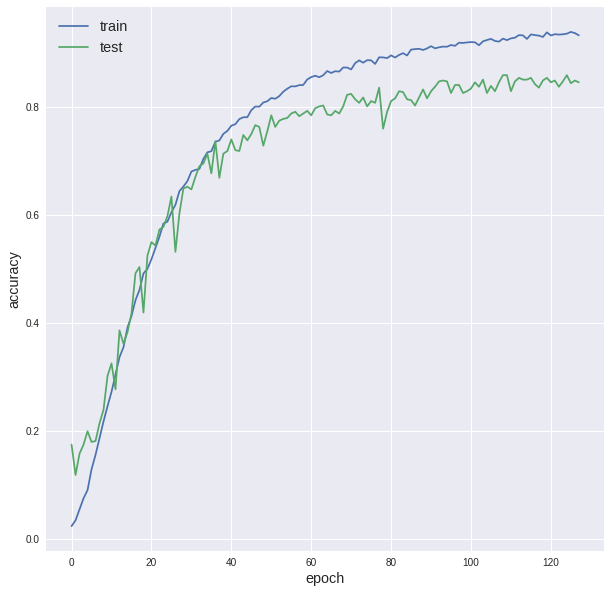

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy', fontsize='x-large')
plt.xlabel('epoch', fontsize='x-large')
plt.legend(['train', 'test'], loc='upper left', fontsize='x-large')

Get predictions from the test set to visualize the results.

In [ ]:
y_pred = model.predict(X_test, batch_size=len(X_test), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

605/605 [==============================] - 2s 3ms/step


We know that we reached the overall accuracy of 85%.
A more in-depth view we can get by looking at the confusion matix.

In [ ]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(0, len(classes), 2)
    plt.xticks(tick_marks, classes[tick_marks], rotation=90)
    plt.yticks(tick_marks, classes[tick_marks])
    plt.ylabel('True label', fontsize='x-large')
    plt.xlabel('Predicted label', fontsize='x-large')

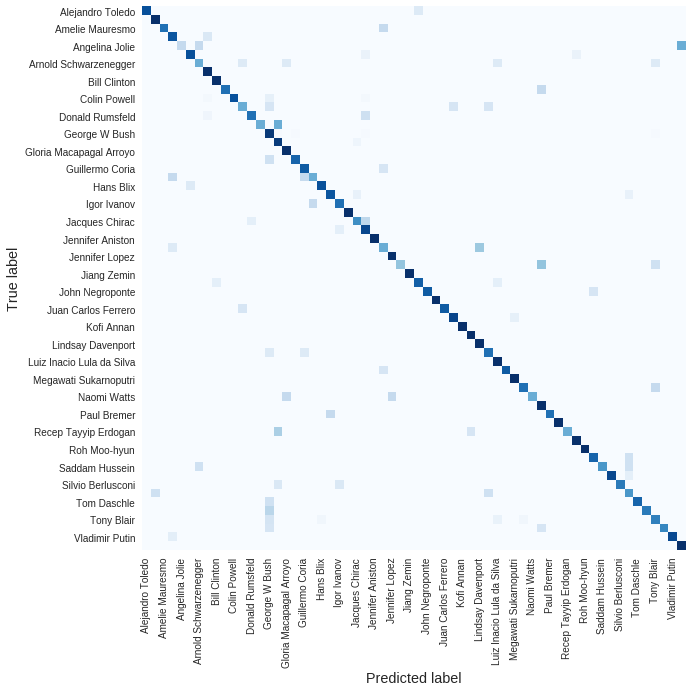

In [ ]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, classes=target_names)
plt.grid(False)

Assuming that all classes have the same importnace, more appropriate measure would be the average accuracy among all classes.

In [ ]:
def plot_barh(labels, values):
    fig = plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(labels))
    plt.barh(y_pos, values, align='center', alpha=0.5)
    plt.yticks(y_pos, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.05))
    plt.xlabel('accuracy', fontsize='x-large')
    plt.axes().xaxis.grid(color='black', linestyle='-', linewidth=0.5)
    axes = plt.gca()
    axes.set_xlim([0.0, 1.0])
    axes.axvline(np.mean(values), color='green', linewidth=2)
    plt.tight_layout()

In [ ]:
class_accuracies = [cm[i, i] for i in range(cm.shape[0])]

average accuracy: 81.2%


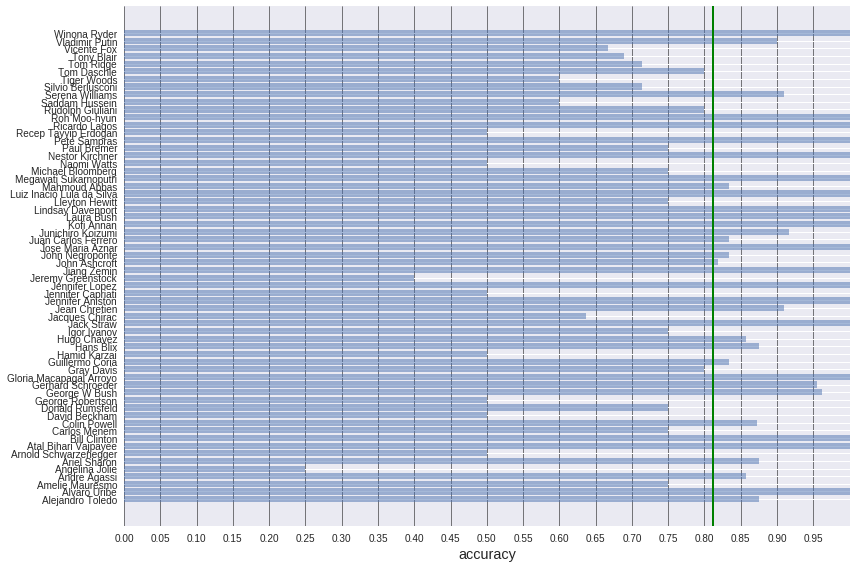

In [ ]:
plot_barh(target_names, class_accuracies)
print('average accuracy: {}%'.format(np.round(np.mean(class_accuracies) * 100.0, 1)))